Notebook 2: Data Alignment and Synchronization Tutorial
==============================================================

[Click to view on Google Colab](https://colab.research.google.com/drive/1a4Nb3y8Wz5xt88JKJ_f5bn_nistPAiOb?usp=sharing)    
  
This tutorial teaches data alignment concepts step by step.
We'll start with simple examples and gradually build up complexity.

Learning Path:
1. Understanding what temporal alignment means
2. Simple time-based alignment
3. Detecting missing data
4. Cross-modal validation basics
5. Building a complete alignment system

### Import necessary libraries

In [ ]:
# !pip install numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict
from dataclasses import dataclass

---

### Python dataclass for segments

In [2]:
@dataclass
class SimpleSegment:
    """A simple segment with start time, end time, and description."""
    start_time: float
    end_time: float
    description: str
    
    def duration(self) -> float:
        """How long is this segment?"""
        return self.end_time - self.start_time
    
    def __str__(self):
        return f"[{self.start_time:.1f}s-{self.end_time:.1f}s]: {self.description}"
    
    def __hash__(self):
        """Make the object hashable so it can be used in sets."""
        return hash((self.start_time, self.end_time, self.description))
    
    def __eq__(self, other):
        """Define equality for proper set operations."""
        if not isinstance(other, SimpleSegment):
            return False
        return (self.start_time == other.start_time and 
                self.end_time == other.end_time and 
                self.description == other.description)

---

### Understanding Temporal Alignment

In [3]:
def step1_understanding_temporal_alignment(verbose=True):
    """
    Step 1: What is temporal alignment?
    
    Imagine you have a video and captions. Sometimes the captions don't 
    perfectly match when things happen in the video. Temporal alignment 
    helps us match them up correctly.
    """
    if verbose:
        print("=" * 60)
        print("STEP 1: Understanding Temporal Alignment")
        print("=" * 60)
        
        print("\n🎬 Let's say we have a simple video with these scenes:")
    
    # Simple video segments
    video_segments = [
        SimpleSegment(0.0, 3.0, "Person walks into room"),
        SimpleSegment(3.0, 6.0, "Person sits down"),
        SimpleSegment(6.0, 9.0, "Person starts reading"),
    ]
    
    if verbose:
        for i, segment in enumerate(video_segments, 1):
            print(f"   Video {i}: {segment}")
        
        print("\n📝 And we have captions that describe what's happening:")
    
    # Caption segments (slightly misaligned)
    text_segments = [
        SimpleSegment(0.5, 3.5, "Someone enters the room"),
        SimpleSegment(3.2, 6.2, "The person takes a seat"),
        SimpleSegment(6.1, 9.1, "Reading begins"),
    ]
    
    if verbose:
        for i, segment in enumerate(text_segments, 1):
            print(f"   Caption {i}: {segment}")
        
        print("\n🤔 Notice the problem?")
        print("   - Video starts at 0.0s, but caption starts at 0.5s")
        print("   - There's a small time difference (offset) between video and text")
        print("   - This is what we need to 'align' or match up!")
    
    return video_segments, text_segments

video_segments, text_segments = step1_understanding_temporal_alignment()


STEP 1: Understanding Temporal Alignment

🎬 Let's say we have a simple video with these scenes:
   Video 1: [0.0s-3.0s]: Person walks into room
   Video 2: [3.0s-6.0s]: Person sits down
   Video 3: [6.0s-9.0s]: Person starts reading

📝 And we have captions that describe what's happening:
   Caption 1: [0.5s-3.5s]: Someone enters the room
   Caption 2: [3.2s-6.2s]: The person takes a seat
   Caption 3: [6.1s-9.1s]: Reading begins

🤔 Notice the problem?
   - Video starts at 0.0s, but caption starts at 0.5s
   - There's a small time difference (offset) between video and text
   - This is what we need to 'align' or match up!


---

### Simple Alignment

In [4]:
def step2_simple_alignment():
    """
    Step 2: Let's try a simple alignment method
    
    We'll use the "closest in time" approach - match each video segment
    with the text segment that starts closest to it in time.
    
    Note: This function uses the video_segments and text_segments from Step 1
    """
    print("\n" + "=" * 60)
    print("STEP 2: Simple Time-Based Alignment")
    print("=" * 60)
    
    print("\n🔍 Let's find the best matches:")
    
    alignments = []
    
    for i, video_seg in enumerate(video_segments):
        print(f"\n   Looking for match for Video {i+1}: {video_seg}")
        
        best_match = None
        smallest_time_difference = float('inf')  # Start with a very large number
        
        for j, text_seg in enumerate(text_segments):
            # Calculate how far apart the start times are
            time_difference = abs(video_seg.start_time - text_seg.start_time)
            print(f"      Caption {j+1} starts {time_difference:.1f}s away")
            
            # Is this the closest match so far?
            if time_difference < smallest_time_difference:
                smallest_time_difference = time_difference
                best_match = (j, text_seg)
        
        if best_match:
            alignments.append({
                'video': video_seg,
                'text': best_match[1],
                'time_offset': smallest_time_difference
            })
            print(f"   ✅ Best match: Caption {best_match[0]+1} (offset: {smallest_time_difference:.1f}s)")
    
    print(f"\n📊 Alignment Results:")
    for i, alignment in enumerate(alignments, 1):
        print(f"   Pair {i}:")
        print(f"      Video: {alignment['video']}")
        print(f"      Text:  {alignment['text']}")
        print(f"      Time difference: {alignment['time_offset']:.1f} seconds")
    
    return alignments

alignments = step2_simple_alignment()


STEP 2: Simple Time-Based Alignment

🔍 Let's find the best matches:

   Looking for match for Video 1: [0.0s-3.0s]: Person walks into room
      Caption 1 starts 0.5s away
      Caption 2 starts 3.2s away
      Caption 3 starts 6.1s away
   ✅ Best match: Caption 1 (offset: 0.5s)

   Looking for match for Video 2: [3.0s-6.0s]: Person sits down
      Caption 1 starts 2.5s away
      Caption 2 starts 0.2s away
      Caption 3 starts 3.1s away
   ✅ Best match: Caption 2 (offset: 0.2s)

   Looking for match for Video 3: [6.0s-9.0s]: Person starts reading
      Caption 1 starts 5.5s away
      Caption 2 starts 2.8s away
      Caption 3 starts 0.1s away
   ✅ Best match: Caption 3 (offset: 0.1s)

📊 Alignment Results:
   Pair 1:
      Video: [0.0s-3.0s]: Person walks into room
      Text:  [0.5s-3.5s]: Someone enters the room
      Time difference: 0.5 seconds
   Pair 2:
      Video: [3.0s-6.0s]: Person sits down
      Text:  [3.2s-6.2s]: The person takes a seat
      Time difference: 0.2 seco

---

### Alignment Visualization


STEP 3: Visualizing Alignment


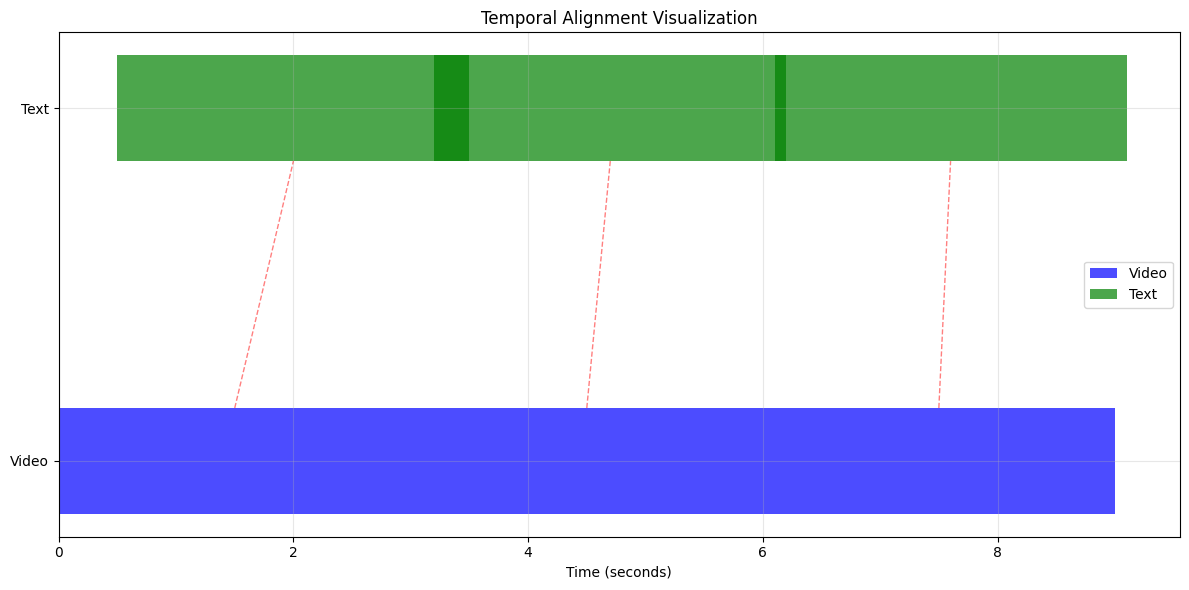


📊 Alignment visualization displayed above


In [5]:
def step3_visualize_alignment():
    """
    Step 3: Let's visualize what alignment looks like
    
    A picture is worth a thousand words! Let's draw a timeline.
    
    Note: This function uses the alignments from Step 2
    """
    print("\n" + "=" * 60)
    print("STEP 3: Visualizing Alignment")
    print("=" * 60)
    
    # Create a simple visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Plot video segments
    for i, alignment in enumerate(alignments):
        video_seg = alignment['video']
        text_seg = alignment['text']
        
        # Video segments in blue
        ax.barh(0, video_seg.duration(), left=video_seg.start_time, 
                height=0.3, alpha=0.7, color='blue', 
                label='Video' if i == 0 else "")
        
        # Text segments in green
        ax.barh(1, text_seg.duration(), left=text_seg.start_time, 
                height=0.3, alpha=0.7, color='green',
                label='Text' if i == 0 else "")
        
        # Draw connection lines
        video_center = video_seg.start_time + video_seg.duration() / 2
        text_center = text_seg.start_time + text_seg.duration() / 2
        ax.plot([video_center, text_center], [0.15, 0.85], 
                'r--', alpha=0.5, linewidth=1)
    
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Video', 'Text'])
    ax.set_xlabel('Time (seconds)')
    ax.set_title('Temporal Alignment Visualization')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("\n📊 Alignment visualization displayed above")

step3_visualize_alignment()

---

### Finding Missing Data

In [6]:
def step4_handling_missing_data():
    """
    Step 4: What happens when data is missing?
    
    In real life, sometimes we have video without captions, or captions 
    without video. Let's learn how to handle this.
    """
    print("\n" + "=" * 60)
    print("STEP 4: Handling Missing Data")
    print("=" * 60)
    
    print("\n🎬 Let's create a more realistic scenario:")
    
    # Video with some segments
    video_segments_missing = [
        SimpleSegment(0.0, 2.0, "Opening scene"),
        SimpleSegment(2.0, 5.0, "Main action"),
        SimpleSegment(5.0, 7.0, "Dialogue scene"),
        SimpleSegment(7.0, 10.0, "Closing scene"),
    ]
    
    # Text with missing segments (notice gaps!)
    text_segments_missing = [
        SimpleSegment(0.2, 2.2, "The story begins"),
        # Missing caption for "Main action" (2.0-5.0)
        SimpleSegment(5.1, 7.1, "Characters talking"),
        SimpleSegment(7.2, 10.2, "The end"),
    ]
    
    print("\n📹 Video segments:")
    for i, seg in enumerate(video_segments_missing, 1):
        print(f"   {i}. {seg}")
    
    print("\n📝 Text segments (notice something missing?):")
    for i, seg in enumerate(text_segments_missing, 1):
        print(f"   {i}. {seg}")
    
    print("\n🔍 Let's try to align them and see what happens:")
    
    alignments_missing = []
    unmatched_video = []
    text_segments_copy = text_segments_missing.copy()  # Make a copy so we can modify it
    
    # Try to match each video segment
    for video_seg in video_segments_missing:
        best_match = None
        best_distance = float('inf')
        
        for text_seg in text_segments_copy:
            distance = abs(video_seg.start_time - text_seg.start_time)
            if distance < best_distance and distance < 2.0:  # Within 2 seconds
                best_distance = distance
                best_match = text_seg
        
        if best_match:
            alignments_missing.append({'video': video_seg, 'text': best_match})
            # Remove the matched text so it can't be matched again
            text_segments_copy.remove(best_match)
        else:
            unmatched_video.append(video_seg)
    
    # Any remaining text segments are unmatched
    unmatched_text = text_segments_copy
    
    print(f"\n✅ Successfully aligned: {len(alignments_missing)} pairs")
    for i, alignment in enumerate(alignments_missing, 1):
        print(f"   {i}. Video: {alignment['video'].description} ↔ Text: {alignment['text'].description}")
    
    print(f"\n❌ Unmatched video segments: {len(unmatched_video)}")
    for seg in unmatched_video:
        print(f"   - {seg}")
    
    print(f"\n❌ Unmatched text segments: {len(unmatched_text)}")
    for seg in unmatched_text:
        print(f"   - {seg}")
    
    print("\n💡 Key insights:")
    print("   - Not everything can be perfectly aligned")
    print("   - Missing data is common in real applications")
    print("   - We need strategies to handle unmatched segments")
    
    return alignments_missing, unmatched_video, unmatched_text

alignments_missing, unmatched_video, unmatched_text = step4_handling_missing_data()



STEP 4: Handling Missing Data

🎬 Let's create a more realistic scenario:

📹 Video segments:
   1. [0.0s-2.0s]: Opening scene
   2. [2.0s-5.0s]: Main action
   3. [5.0s-7.0s]: Dialogue scene
   4. [7.0s-10.0s]: Closing scene

📝 Text segments (notice something missing?):
   1. [0.2s-2.2s]: The story begins
   2. [5.1s-7.1s]: Characters talking
   3. [7.2s-10.2s]: The end

🔍 Let's try to align them and see what happens:

✅ Successfully aligned: 3 pairs
   1. Video: Opening scene ↔ Text: The story begins
   2. Video: Dialogue scene ↔ Text: Characters talking
   3. Video: Closing scene ↔ Text: The end

❌ Unmatched video segments: 1
   - [2.0s-5.0s]: Main action

❌ Unmatched text segments: 0

💡 Key insights:
   - Not everything can be perfectly aligned
   - Missing data is common in real applications
   - We need strategies to handle unmatched segments


---

### Cross Modal Validation

In [7]:
def step5_cross_modal_validation():
    """
    Step 5: Cross-modal validation - checking if our alignments make sense
    
    Just because two segments are close in time doesn't mean they actually 
    match in content. Let's add some basic validation.
    """
    print("\n" + "=" * 60)
    print("STEP 5: Cross-Modal Validation")
    print("=" * 60)
    
    print("\n🧠 Let's check if our alignments actually make sense...")
    print("We'll use simple keyword matching to validate alignments.")
    
    # Create test data with some good and bad alignments
    video_segments_validation = [
        SimpleSegment(0.0, 3.0, "person walking in park"),
        SimpleSegment(3.0, 6.0, "dog running and playing"),
        SimpleSegment(6.0, 9.0, "children on playground"),
    ]
    
    text_segments_validation = [
        SimpleSegment(0.2, 3.2, "someone walks through the park"),
        SimpleSegment(3.1, 6.1, "a dog plays energetically"),
        SimpleSegment(6.2, 9.2, "kids having fun at playground"),
    ]
    
    print("\n📹 Video segments:")
    for i, seg in enumerate(video_segments_validation, 1):
        print(f"   {i}. {seg}")
    
    print("\n📝 Text segments:")
    for i, seg in enumerate(text_segments_validation, 1):
        print(f"   {i}. {seg}")
    
    # Simple alignment based on time
    alignments_validation = []
    text_segments_copy = text_segments_validation.copy()
    
    for video_seg in video_segments_validation:
        best_match = None
        best_distance = float('inf')
        
        for text_seg in text_segments_copy:
            distance = abs(video_seg.start_time - text_seg.start_time)
            if distance < best_distance:
                best_distance = distance
                best_match = text_seg
        
        alignments_validation.append({
            'video': video_seg,
            'text': best_match,
            'time_distance': best_distance
        })
        text_segments_copy.remove(best_match)  # Prevent double matching
    
    print(f"\n🔍 Now let's validate these alignments using content similarity:")
    
    def simple_content_similarity(video_desc: str, text_desc: str) -> float:
        """
        Simple content similarity based on common words.
        Returns a score between 0 and 1.
        """
        video_words = set(video_desc.lower().split())
        text_words = set(text_desc.lower().split())
        
        # Find common words
        common_words = video_words.intersection(text_words)
        total_words = video_words.union(text_words)
        
        # Calculate similarity (Jaccard similarity)
        similarity = len(common_words) / len(total_words) if total_words else 0
        return similarity
    
    validated_alignments = []
    
    for i, alignment in enumerate(alignments_validation, 1):
        video_desc = alignment['video'].description
        text_desc = alignment['text'].description
        
        content_similarity = simple_content_similarity(video_desc, text_desc)
        time_quality = 1.0 / (1.0 + alignment['time_distance'])  # Better if closer in time
        
        # Combined score (you can adjust these weights)
        overall_score = 0.7 * content_similarity + 0.3 * time_quality
        
        alignment['content_similarity'] = content_similarity
        alignment['overall_score'] = overall_score
        
        print(f"\n   Alignment {i}:")
        print(f"      Video: {video_desc}")
        print(f"      Text:  {text_desc}")
        print(f"      Time distance: {alignment['time_distance']:.1f}s")
        print(f"      Content similarity: {content_similarity:.2f}")
        print(f"      Overall score: {overall_score:.2f}")
        
        # Only keep high-quality alignments
        if overall_score > 0.3:  # Lower threshold for better demonstration
            validated_alignments.append(alignment)
            print(f"      ✅ ACCEPTED")
        else:
            print(f"      ❌ REJECTED (low quality)")
    
    print(f"\n📊 Validation Results:")
    print(f"   - Original alignments: {len(alignments_validation)}")
    print(f"   - Validated alignments: {len(validated_alignments)}")
    print(f"   - Rejection rate: {(len(alignments_validation) - len(validated_alignments)) / len(alignments_validation) * 100:.1f}%")
    
    return validated_alignments

validated_alignments = step5_cross_modal_validation()


STEP 5: Cross-Modal Validation

🧠 Let's check if our alignments actually make sense...
We'll use simple keyword matching to validate alignments.

📹 Video segments:
   1. [0.0s-3.0s]: person walking in park
   2. [3.0s-6.0s]: dog running and playing
   3. [6.0s-9.0s]: children on playground

📝 Text segments:
   1. [0.2s-3.2s]: someone walks through the park
   2. [3.1s-6.1s]: a dog plays energetically
   3. [6.2s-9.2s]: kids having fun at playground

🔍 Now let's validate these alignments using content similarity:

   Alignment 1:
      Video: person walking in park
      Text:  someone walks through the park
      Time distance: 0.2s
      Content similarity: 0.12
      Overall score: 0.34
      ✅ ACCEPTED

   Alignment 2:
      Video: dog running and playing
      Text:  a dog plays energetically
      Time distance: 0.1s
      Content similarity: 0.14
      Overall score: 0.37
      ✅ ACCEPTED

   Alignment 3:
      Video: children on playground
      Text:  kids having fun at playgr

---

### Data Alignment Pipeline

In [8]:
def step6_complete_alignment_system():
    """
    Step 6: Putting it all together - a complete alignment pipeline
    
    Now let's combine everything we've learned into a simple but complete
    alignment system.
    """
    print("\n" + "=" * 60)
    print("STEP 6: Complete Alignment Pipeline")
    print("=" * 60)
    
    print("\n🔧 Let's build a complete alignment system step by step:")
    
    class SimpleAligner:
        """A simple but complete alignment system for beginners."""
        
        def __init__(self, max_time_distance=2.0, min_content_similarity=0.3):
            self.max_time_distance = max_time_distance
            self.min_content_similarity = min_content_similarity
        
        def align(self, video_segments: List[SimpleSegment], 
                 text_segments: List[SimpleSegment]) -> Dict:
            """Main alignment function."""
            
            print(f"🎯 Aligning {len(video_segments)} video segments with {len(text_segments)} text segments")
            
            # Step 1: Time-based matching
            time_matches = self._find_time_matches(video_segments, text_segments)
            print(f"   Found {len(time_matches)} time-based matches")
            
            # Step 2: Content validation
            validated_matches = self._validate_content(time_matches)
            print(f"   {len(validated_matches)} matches passed content validation")
            
            # Step 3: Identify unmatched segments
            unmatched = self._find_unmatched(video_segments, text_segments, validated_matches)
            
            return {
                'alignments': validated_matches,
                'unmatched_video': unmatched['video'],
                'unmatched_text': unmatched['text'],
                'stats': self._calculate_stats(validated_matches, unmatched)
            }
        
        def _find_time_matches(self, video_segments, text_segments):
            """Find matches based on temporal proximity."""
            matches = []
            available_text = text_segments.copy()
            
            for video_seg in video_segments:
                best_match = None
                best_distance = float('inf')
                
                for text_seg in available_text:
                    distance = abs(video_seg.start_time - text_seg.start_time)
                    if distance < best_distance and distance <= self.max_time_distance:
                        best_distance = distance
                        best_match = text_seg
                
                if best_match:
                    matches.append({
                        'video': video_seg,
                        'text': best_match,
                        'time_distance': best_distance
                    })
                    available_text.remove(best_match)
            
            return matches
        
        def _validate_content(self, matches):
            """Validate matches using content similarity."""
            validated = []
            
            for match in matches:
                similarity = self._content_similarity(
                    match['video'].description, 
                    match['text'].description
                )
                
                if similarity >= self.min_content_similarity:
                    match['content_similarity'] = similarity
                    validated.append(match)
            
            return validated
        
        def _content_similarity(self, video_desc, text_desc):
            """Simple content similarity calculation."""
            video_words = set(video_desc.lower().split())
            text_words = set(text_desc.lower().split())
            
            common = video_words.intersection(text_words)
            total = video_words.union(text_words)
            
            return len(common) / len(total) if total else 0
        
        def _find_unmatched(self, video_segments, text_segments, matches):
            """Find segments that couldn't be matched."""
            matched_video = set()
            matched_text = set()
            
            for match in matches:
                matched_video.add(match['video'])
                matched_text.add(match['text'])
            
            return {
                'video': [seg for seg in video_segments if seg not in matched_video],
                'text': [seg for seg in text_segments if seg not in matched_text]
            }
        
        def _calculate_stats(self, matches, unmatched):
            """Calculate alignment statistics."""
            total_video = len(matches) + len(unmatched['video'])
            total_text = len(matches) + len(unmatched['text'])
            
            return {
                'alignment_rate': len(matches) / total_video if total_video > 0 else 0,
                'avg_time_distance': np.mean([m['time_distance'] for m in matches]) if matches else 0,
                'avg_content_similarity': np.mean([m['content_similarity'] for m in matches]) if matches else 0
            }
    
    # Test our complete system
    print(f"\n🧪 Testing our complete alignment system:")
    
    # Create test data
    video_segments_final = [
        SimpleSegment(0.0, 3.0, "person walking dog"),
        SimpleSegment(3.5, 6.0, "dog playing fetch"),
        SimpleSegment(7.0, 10.0, "people sitting park"),
        SimpleSegment(11.0, 14.0, "children playground"),
    ]
    
    text_segments_final = [
        SimpleSegment(0.2, 3.2, "someone walks their dog"),
        SimpleSegment(3.7, 6.2, "dog plays with ball"),
        SimpleSegment(7.1, 10.1, "people relaxing in park"),
        # Missing text for children playground
        SimpleSegment(15.0, 18.0, "birds flying overhead"),  # Extra text
    ]
    
    # Run alignment
    aligner = SimpleAligner(max_time_distance=1.0, min_content_similarity=0.1)  # Lower threshold
    results = aligner.align(video_segments_final, text_segments_final)
    
    # Display results
    print(f"\n📊 Final Results:")
    print(f"   ✅ Successful alignments: {len(results['alignments'])}")
    for i, alignment in enumerate(results['alignments'], 1):
        print(f"      {i}. Video: {alignment['video'].description}")
        print(f"         Text:  {alignment['text'].description}")
        print(f"         Time offset: {alignment['time_distance']:.1f}s")
        print(f"         Content similarity: {alignment['content_similarity']:.2f}")
    
    print(f"\n   ❌ Unmatched video: {len(results['unmatched_video'])}")
    for seg in results['unmatched_video']:
        print(f"      - {seg}")
    
    print(f"\n   ❌ Unmatched text: {len(results['unmatched_text'])}")
    for seg in results['unmatched_text']:
        print(f"      - {seg}")
    
    stats = results['stats']
    print(f"\n   📈 Statistics:")
    print(f"      - Alignment rate: {stats['alignment_rate']:.1%}")
    print(f"      - Average time distance: {stats['avg_time_distance']:.2f}s")
    print(f"      - Average content similarity: {stats['avg_content_similarity']:.2f}")
    
    return results

final_results = step6_complete_alignment_system()


STEP 6: Complete Alignment Pipeline

🔧 Let's build a complete alignment system step by step:

🧪 Testing our complete alignment system:
🎯 Aligning 4 video segments with 4 text segments
   Found 3 time-based matches
   3 matches passed content validation

📊 Final Results:
   ✅ Successful alignments: 3
      1. Video: person walking dog
         Text:  someone walks their dog
         Time offset: 0.2s
         Content similarity: 0.17
      2. Video: dog playing fetch
         Text:  dog plays with ball
         Time offset: 0.2s
         Content similarity: 0.17
      3. Video: people sitting park
         Text:  people relaxing in park
         Time offset: 0.1s
         Content similarity: 0.40

   ❌ Unmatched video: 1
      - [11.0s-14.0s]: children playground

   ❌ Unmatched text: 1
      - [15.0s-18.0s]: birds flying overhead

   📈 Statistics:
      - Alignment rate: 75.0%
      - Average time distance: 0.17s
      - Average content similarity: 0.24


---